# Stock Market Forecasting (NIFTY-50 Stocks)
## Business Problem:
 Customers are interested in understanding what stocks to invest in, given data about a stock and its past performance. This would help the customers make an educated investment choice. Thus, given a particular stock, and its information, the goal is to be able to predict or forecast how the stock would do in the future

## Data Dictionary (Yahoo Finance Data):
* <b>Date:</b> Represents the specific day the stock data was recorded
* <b>Open:</b> The first price at which the stock was traded when the market opened. It can be used to gauge the market's initial reaction to news and events
* <b>High:</b> The maximum price at which the stock was traded during the session. It indicates the stock's peak performance on a given day
* <b>Low:</b> The minimum price at which the stock was traded during the session. It provides insight into the stock's lowest performance on a given day
* <b>Close:</b> The final price at which the stock was traded when the market closed. It is often used as a reference point for the stock's daily performance
* <b>Adj Close:</b> Adjusted Close takes into account all corporate actions and adjustments. This is especially useful for back-testing and historical analysis as it reflects the stock's actual value more accurately
* <b>Volume:</b> Indicates the total number of shares traded during the day. High volume can indicate strong interest in the stock, while low volume can suggest weak interest
* <b>Ticker:</b> A unique identifier for the stock, typically an abbreviation of the company name or another identifier used on the stock exchange


In [63]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import os
import warnings
from sklearn.metrics import precision_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from scipy.stats import uniform, randint
from tqdm import tqdm
import pickle

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [2]:
# Defining a list of 49 stocks from the NIFTY-50 stocks
# Since one of the stocks - 'HDFC-NS' got de-listed, removing it from the list

nifty_50_stocks = [
    'ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS',
    'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS',
    'HINDUNILVR.NS', 'ICICIBANK.NS', 'ITC.NS', 'IOC.NS', 'INDUSINDBK.NS', 'INFY.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS',
    'M&M.NS', 'MARUTI.NS', 'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SHREECEM.NS', 'SBIN.NS',
    'SUNPHARMA.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'UPL.NS', 'ULTRACEMCO.NS', 'WIPRO.NS'
]

print(len(nifty_50_stocks))

49


# Defining Utility Functions

In [3]:
def get_historical_data(stocks, start_date='2015-01-01', end_date='today'):

  """
  Given a list of stocks, download historical stock data from Yahoo Finance.
  Args:
    stocks: A list containing the ticker code for different stocks
    start_date: The starting date from which data is to be fetched
    end_date: Date upto which data is to be fetched. If set to 'today', then latest date would be picked

  Returns:
    A DataFrame containing the historical stock data for the given stocks
  """

  # Defining the range of dates
  if end_date == 'today':
    end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

  # Create an empty DataFrame to store the data
  stock_data = pd.DataFrame()

  # Fetch the stock price data for each stock
  for stock in stocks:
      data = yf.download(stock, start=start_date, end=end_date)
      # Add a column for the stock symbol
      data['Ticker'] = stock
      # Append the data to the main DataFrame
      stock_data = pd.concat([stock_data, data])

  # Sort the stock data by the Date column
  stock_data.sort_values(by='Date', inplace=True)

  # Reset index to have a proper DataFrame structure
  stock_data.reset_index(inplace=True)

  return stock_data

In [4]:
def stock_performance(df, period='year'):
    """
    Calculates the top 10 and bottom 10 stocks based on the change percentage in the stock median adj closing prices within a specified time period

    Args:
        df: dataframe containing the stocks data
        period: Time period for which the top and bottom 10 stocks are to be calculated (either of 'year' or 'month')

    Returns:
        A tuple containing the top 10 stocks and bottom 10 stocks returned as dataframes
    """

    # Determine the start date based on the specified period
    if period == 'year':
        start_date = (pd.to_datetime('today') - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
    elif period == 'month':
        start_date = (pd.to_datetime('today') - pd.DateOffset(months=1)).strftime('%Y-%m-%d')

    # Filter the dataframe based on the start date
    df_filtered = df[df['Date'] >= start_date]
    # Sort the dataframe by Ticker and Date
    df_filtered = df_filtered.sort_values(by=['Ticker', 'Date'])

    # Calculate the median of Adj Close prices for each Ticker within the specified period
    df_grouped = df_filtered.groupby('Ticker').agg({'Adj Close': 'median'}).reset_index()
    df_grouped.columns = ['Ticker', 'Median_Adj_Close_Current']

    # Get the first and last date in the filtered data
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Filter the dataframe for the previous period (one year or one month before the start date)
    if period == 'year':
        previous_start_date = (pd.to_datetime(start_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
    elif period == 'month':
        previous_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
    previous_end_date = start_date

    df_previous_period = df[(df['Date'] >= previous_start_date) & (df['Date'] < previous_end_date)]
    df_previous_period = df_previous_period.sort_values(by=['Ticker', 'Date'])

    # Calculate the median of Adj Close prices for each Ticker in the previous period
    df_previous_grouped = df_previous_period.groupby('Ticker').agg({'Adj Close': 'median'}).reset_index()
    df_previous_grouped.columns = ['Ticker', 'Median_Adj_Close_Previous']

    # Merge the current period and previous period dataframes
    df_merged = pd.merge(df_grouped, df_previous_grouped, on='Ticker', how='inner')

    # Compute the change percentage in the stock
    df_merged['Change_Percentage'] = np.round(((df_merged['Median_Adj_Close_Current'] - df_merged['Median_Adj_Close_Previous']) / df_merged['Median_Adj_Close_Previous']) * 100, 2)

    # Sort and get top 10 stocks
    top_10_stocks = df_merged.sort_values('Change_Percentage', ascending=False)[['Ticker', 'Change_Percentage']][:10]

    # Sort and get bottom 10 stocks
    bottom_10_stocks = df_merged.sort_values('Change_Percentage', ascending=True)[['Ticker', 'Change_Percentage']][:10]

    return top_10_stocks, bottom_10_stocks


In [5]:
def get_time_based_splits(df, cut_off_threshold=0.9, validation_size=0.05):
    """
    Args:
        df: Dataframe that is supposed to be split into train and test
        cut_off_threshold: The percentage of data to be used for training
        validation_size: The percentage of data to be used for validation
    Returns:
        A tuple containing the training and testing dataframes (X_train, y_train, X_val, y_val, X_test, y_test)
    """

    # Extracting features and target variable
    X, y = df.drop('Target', axis=1), df['Target']

    # Calculating indices for the splits
    cut_off_idx = int(len(df) * cut_off_threshold)
    val_idx_start = cut_off_idx
    val_idx_end = int(len(df) * (cut_off_threshold + validation_size))

    # Creating the training set
    X_train, y_train = X[:cut_off_idx], y[:cut_off_idx]

    # Creating the validation set
    X_val, y_val = X[val_idx_start:val_idx_end], y[val_idx_start:val_idx_end]

    # Creating the test set
    X_test, y_test = X[val_idx_end:], y[val_idx_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
def evaluate_model(y_true, y_pred_prob, title, threshold=0.5):
    """
    The function takes in y_true and y_pred_prob values as lists and then creates a detailed report for the model using:
    1. Precision Score
    2. Confusion Matrix

    Args:
    y_true: List of true labels
    y_pred_prob: List or array of predicted probabilities
    threshold: Threshold to compute predicted class from probabilities
    title: Title for the plots
    """

    # Convert probabilities to predicted class based on threshold
    y_pred = np.where(y_pred_prob >= threshold, 1, 0)

    # Calculating the precision score
    precision = precision_score(y_true, y_pred)

    # Calculating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Printing the metrics
    print(f"Precision Score: {np.round(precision, 2)}")

    # Plotting the Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.suptitle(title)

    plt.tight_layout()
    plt.show()

In [7]:
def target_encoder(feature, target):

    """
    Perform target encoding for a given categorical feature and binary class target.

    Parameters:
    feature (pd.Series): Categorical feature column.
    target (pd.Series): Binary target column.

    Returns:
    encoded_feature: Target-encoded column
    means: Dict containing the target encoded mapping for each category
    """
    # Concat the feature and target to make a dataframe
    df = pd.concat([feature, target], axis=1)
    # Rename the columns
    df.columns = ['Feature', 'Target']

    # Compute the target encodings
    means = df.groupby('Feature')['Target'].mean()

    # Map these means back to the original feature column
    encoded_feature = feature.map(means)

    return encoded_feature, means

In [8]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid):

  """
  Hyperparameter tuning for the XGBoost Model
  Args:
    X_train: Training features
    y_train: Training target
    X_val: Validation features
    y_val: Validation target
    param_grid: Dictionary containing the hyperparameters to be tuned

  Returns:
    best_model: The best model with the best hyperparameters
    best_params: Dictionary containing the best hyperparameters
    best_precision: The precision score of the best model
  """
  best_params = None
  best_model = None
  best_precision = 0

  # Iterate through the parameter grid
  for params in tqdm(ParameterGrid(param_grid)):
      model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
      model.fit(X_train, y_train)

      y_val_pred = model.predict(X_val)
      precision = precision_score(y_val, y_val_pred)

      if precision > best_precision:
          best_precision = precision
          best_params = params
          best_model = model

  return best_model, best_params, best_precision

# EDA, Data Analysis and Data Cleaning

In [9]:
# Loading the stocks data to a dataframe

try:
  # Read the data from csv if it already exists
  df = pd.read_csv('historical_data.csv')
except FileNotFoundError:
  # If data does not exist, then fetch it using Yahoo Finance API and save it
  print('File does not Exist. Fetching Latest data')
  df = get_historical_data(nifty_50_stocks)
  df.to_csv('historical_data.csv', index=False)

File does not Exist. Fetching Latest data


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112633 entries, 0 to 112632
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       112633 non-null  datetime64[ns]
 1   Open       112633 non-null  float64       
 2   High       112633 non-null  float64       
 3   Low        112633 non-null  float64       
 4   Close      112633 non-null  float64       
 5   Adj Close  112633 non-null  float64       
 6   Volume     112633 non-null  int64         
 7   Ticker     112633 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 6.9+ MB


In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2015-01-01,319.000000,322.500000,316.250000,319.549988,304.542145,1456204,ADANIPORTS.NS
1,2015-01-01,867.400024,876.500000,862.250000,872.724976,807.734009,186924,DIVISLAB.NS
2,2015-01-01,826.500000,830.000000,818.099976,822.200012,767.332764,587479,SUNPHARMA.NS
3,2015-01-01,383.000000,383.450012,378.549988,380.049988,173.494568,540225,COALINDIA.NS
4,2015-01-01,1283.500000,1283.500000,1270.500000,1272.775024,1054.449951,366830,TCS.NS


In [12]:
# Checking the shape

df.shape

(112633, 8)

In [13]:
# There are 49 valid stocks present in the dataset

df['Ticker'].nunique()

49

In [14]:
# Checking the frequencies of different stocks since 2015

df['Ticker'].value_counts()

Ticker
ADANIPORTS.NS    2327
DIVISLAB.NS      2327
IOC.NS           2327
KOTAKBANK.NS     2327
ITC.NS           2327
ICICIBANK.NS     2327
LT.NS            2327
HINDUNILVR.NS    2327
M&M.NS           2327
WIPRO.NS         2327
HINDALCO.NS      2327
HEROMOTOCO.NS    2327
NTPC.NS          2327
NESTLEIND.NS     2327
HDFCBANK.NS      2327
ONGC.NS          2327
HCLTECH.NS       2327
POWERGRID.NS     2327
GRASIM.NS        2327
RELIANCE.NS      2327
MARUTI.NS        2327
ASIANPAINT.NS    2327
INFY.NS          2327
JSWSTEEL.NS      2327
INDUSINDBK.NS    2327
EICHERMOT.NS     2327
TECHM.NS         2327
SUNPHARMA.NS     2327
COALINDIA.NS     2327
TCS.NS           2327
CIPLA.NS         2327
TATACONSUM.NS    2327
TATAMOTORS.NS    2327
BHARTIARTL.NS    2327
TATASTEEL.NS     2327
BPCL.NS          2327
BAJAJFINSV.NS    2327
TITAN.NS         2327
BAJFINANCE.NS    2327
UPL.NS           2327
BAJAJ-AUTO.NS    2327
ULTRACEMCO.NS    2327
AXISBANK.NS      2327
SBIN.NS          2327
DRREDDY.NS       2327
SHR

In [15]:
# High level summary of the data

df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,112633,2019-10-04 16:31:08.127458304,2015-01-01 00:00:00,2017-06-08 00:00:00,2019-10-16 00:00:00,2022-02-07 00:00:00,2024-06-07 00:00:00,NaN
Open,112633.0,1725.412798,19.531101,349.100006,747.0,1780.0,31682.400391,3176.492236
High,112633.0,1745.955246,19.693066,354.950012,755.450012,1800.0,32048.0,3216.669407
Low,112633.0,1702.846219,19.02615,343.600006,736.549988,1758.800049,31120.0,3132.473011
Close,112633.0,1723.964742,19.188114,349.100006,746.049988,1780.099976,31748.75,3173.650719
Adj Close,112633.0,1663.008839,15.463521,321.062439,720.136414,1730.373901,31371.873047,3132.660662
Volume,112633.0,7840449.307334,0.0,979478.0,2820247.0,7618033.0,642845990.0,18552323.417074


In [16]:
# Checking for Missing Data

df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64

In [17]:
# Converting Date to a Pandas Datetime datatype

df['Date'] = pd.to_datetime(df['Date'])

### Observations:
* We have stock price data from Jan 2015 upto the present day
* Most stocks have 2324 data points, meaning we have about 464.8 weeks of stock data (given that a standard market week goes from Monday to Friday only)
* Two stocks, SBILIFE.NS and HDFCLIFE.NS have fewer records in the 1600s
* The "Adj Close" column is what we would want to predict later
* There is no missing data in the stocks dataset

## Data Distribution

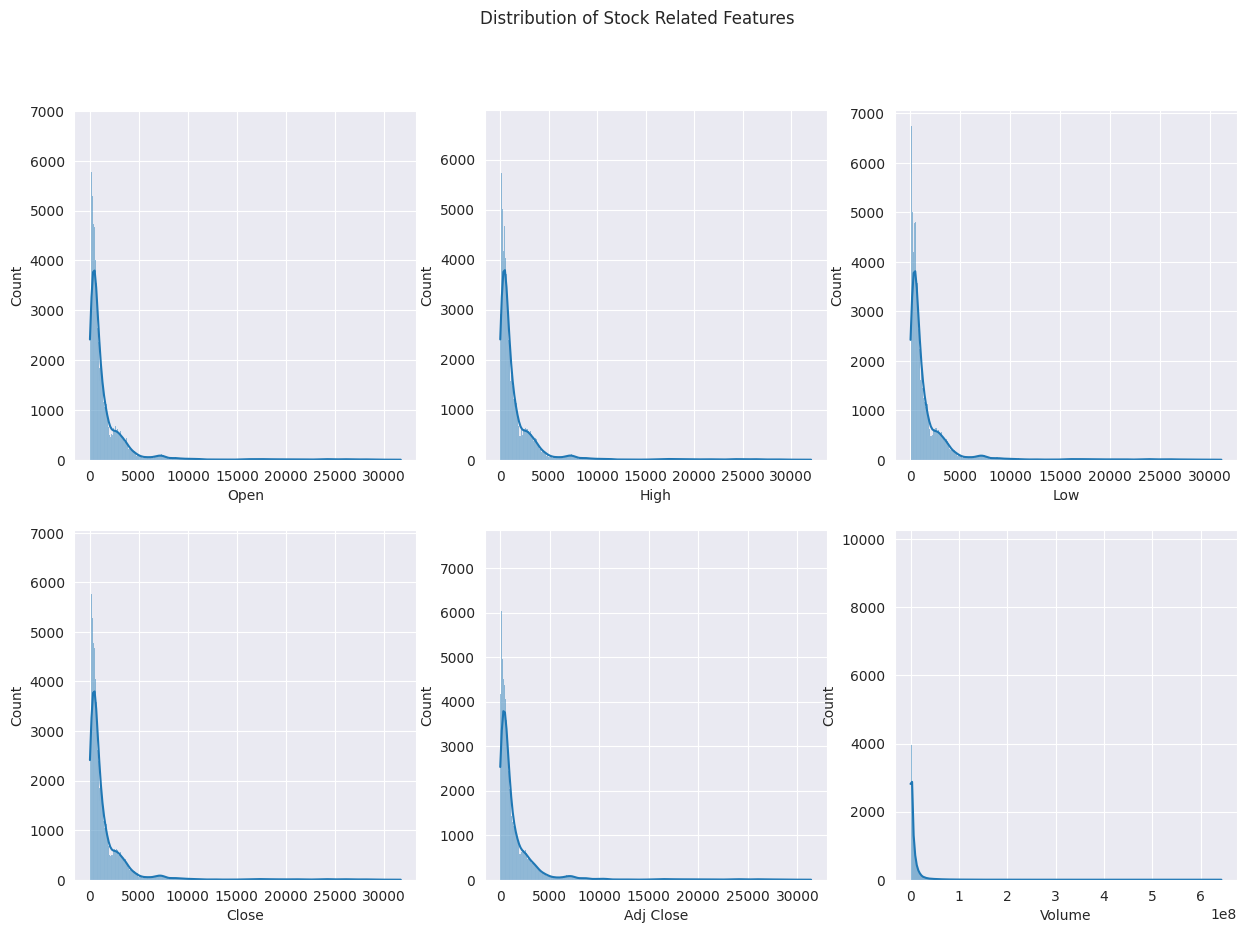

In [18]:
# Plotting the distribution of the numerical columns

# Getting the numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, ax=ax[i // 3, i % 3], kde=True)
    ax[i // 3, i % 3]

plt.suptitle('Distribution of Stock Related Features')
plt.show()


* We see that all these features have a right-skewed distribution, indicating the presence of some higher-than-usual priced stocks that could also be premium stocks


## Analyzing Stocks that have been performing well, as well as those stocks that haven't been doing well in the last month as well as year

In [19]:
# Getting the top 10 and bottom 10 performing stocks for the past year and month

top10_year, bottom10_year = stock_performance(df)
top10_month, bottom10_month = stock_performance(df, period='month')

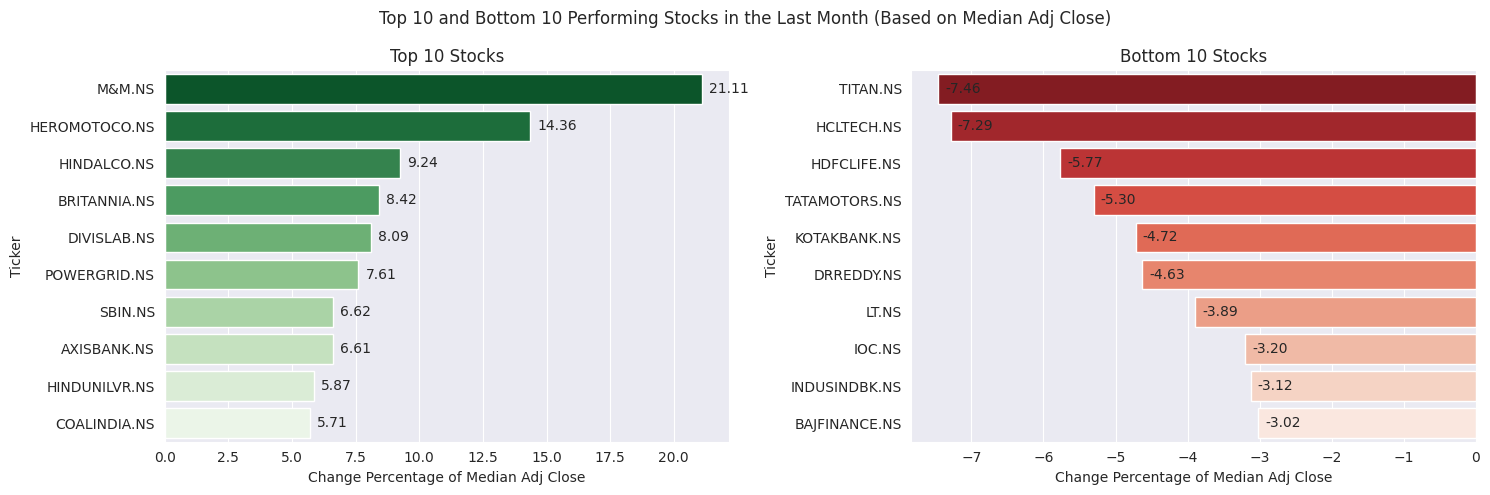

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Top 10 stocks
green_palette = sns.color_palette("Greens", n_colors=len(top10_month))[::-1]
sns.barplot(x=top10_month['Change_Percentage'], y=top10_month['Ticker'], ax=ax1, palette=green_palette)
ax1.set_title('Top 10 Stocks')
ax1.set_xlabel('Change Percentage of Median Adj Close')
ax1.set_ylabel('Ticker')
# Add number labels to top 10
for p in ax1.patches:
    ax1.annotate(format(p.get_width(), '.2f'),
                 (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha = 'left', va = 'center',
                 xytext = (5, 0),
                 textcoords = 'offset points')

# Bottom 10 stocks
red_palette = sns.color_palette("Reds", n_colors=len(bottom10_month))[::-1]
sns.barplot(x=bottom10_month['Change_Percentage'], y=bottom10_month['Ticker'], ax=ax2, palette=red_palette)
ax2.set_title('Bottom 10 Stocks')
ax2.set_xlabel('Change Percentage of Median Adj Close')
ax2.set_ylabel('Ticker')
# Add number labels to bottom 10
for p in ax2.patches:
    ax2.annotate(format(p.get_width(), '.2f'),
                 (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha = 'left', va = 'center',
                 xytext = (5, 0),
                 textcoords = 'offset points')

plt.suptitle('Top 10 and Bottom 10 Performing Stocks in the Last Month (Based on Median Adj Close)')
plt.tight_layout()
plt.show()

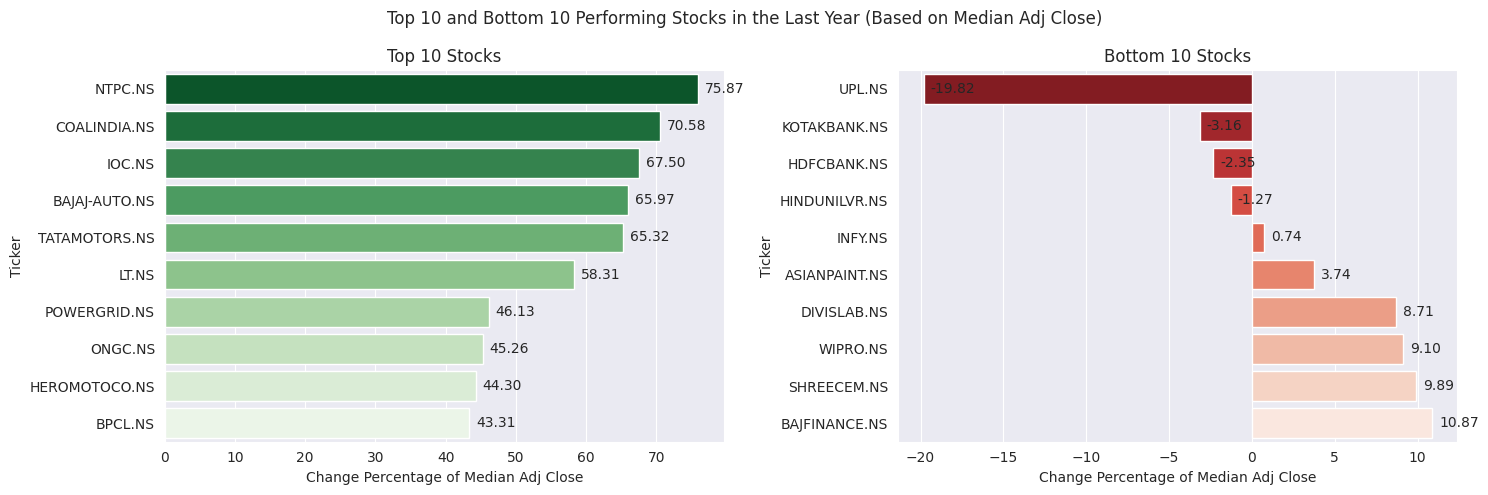

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Top 10 stocks
green_palette = sns.color_palette("Greens", n_colors=len(top10_month))[::-1]
sns.barplot(x=top10_year['Change_Percentage'], y=top10_year['Ticker'], ax=ax1, palette=green_palette)
ax1.set_title('Top 10 Stocks')
ax1.set_xlabel('Change Percentage of Median Adj Close')
ax1.set_ylabel('Ticker')
# Add number labels to top 10
for p in ax1.patches:
    ax1.annotate(format(p.get_width(), '.2f'),
                 (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha = 'left', va = 'center',
                 xytext = (5, 0),
                 textcoords = 'offset points')

# Bottom 10 stocks
red_palette = sns.color_palette("Reds", n_colors=len(bottom10_month))[::-1]
sns.barplot(x=bottom10_year['Change_Percentage'], y=bottom10_year['Ticker'], ax=ax2, palette=red_palette)
ax2.set_title('Bottom 10 Stocks')
ax2.set_xlabel('Change Percentage of Median Adj Close')
ax2.set_ylabel('Ticker')
# Add number labels to bottom 10
for p in ax2.patches:
    ax2.annotate(format(p.get_width(), '.2f'),
                 (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha = 'left', va = 'center',
                 xytext = (5, 0),
                 textcoords = 'offset points')

plt.suptitle('Top 10 and Bottom 10 Performing Stocks in the Last Year (Based on Median Adj Close)')
plt.tight_layout()
plt.show()

### Observations:
* The stock related features have a right-skewed distribution
* <b>MONTHLY ANALYSIS</b> - Based on the monthly analysis of stock closing prices, we observe that the following stocks have grown the most as compared to their last month median adjusted closing values. These could net good gains in the short term:
   1. M&M.NS
   2. HEROMOTOCO.NS
   3. HINDALCO.NS

* Similarly, the following stocks have performed the worst as compared to the last month median adjusted closing values:
   1. HCLTECH.NS
   2. TITAN.NS
   3. HDFCLIFE.NS

* <b>YEARLY ANALYSIS</b> - Based on the yearly analysis of stock closing prices, we observe that the following stocks have grown the most as compared to their last year median adjusted closing values. These could be seen as great investment choices:
   1. NTPC.NS
   2. COALINDIA.NS
   3. IOC.NS

* Similarly, the following stocks have performed poorly as compared to their preivous year median adjusted closing values:
   1. UPL.NS
   2. KOTAKBANK.NS
   3. HDFCBANK.NS


## Analyzing some of the top performers as well as bottom performers over the past year

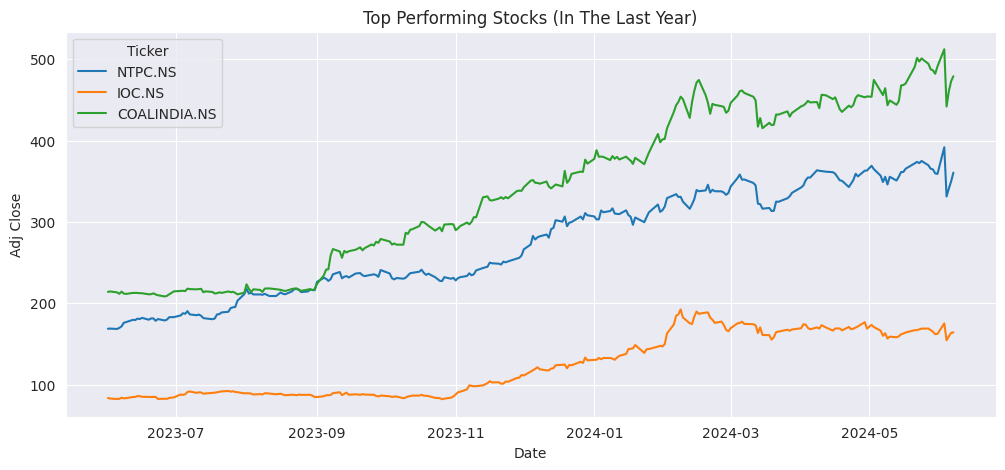

In [22]:
top_performers = df[(df['Ticker'].isin(top10_year['Ticker'][:3])) &
                    (df['Date'] >= '2023-06-01')]

plt.figure(figsize=(12,5))

# Plotting a line chart to visualize performance of the top performing stocks stock
sns.lineplot(x='Date', y='Adj Close', data=top_performers, hue='Ticker')
plt.title('Top Performing Stocks (In The Last Year)')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

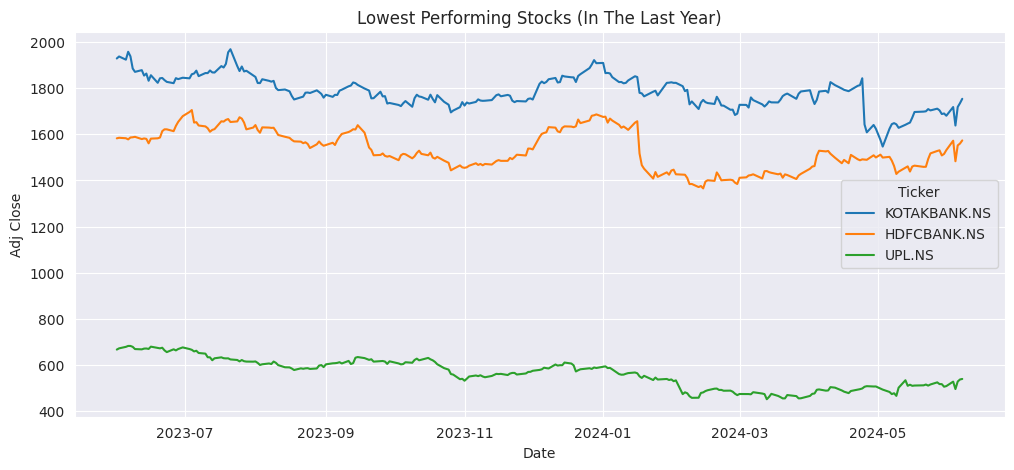

In [23]:
bottom_performers = df[(df['Ticker'].isin(bottom10_year['Ticker'][:3])) &
                       (df['Date'] >= '2023-06-01')]


plt.figure(figsize=(12,5))

# Plotting a line chart to visualize performance of the lowest performing stocks stock

sns.lineplot(x='Date', y='Adj Close', data=bottom_performers, hue='Ticker')
plt.title('Lowest Performing Stocks (In The Last Year)')
plt.xlabel('Date')
plt.ylabel('Adj Close')

plt.show()

### Observations:
* The above two charts highlight how the top performing stocks have a somewhat-consistent upward direction
* Similarly, the poor performers have a downward trend over the last year
* What's important to notice is that a stock's past performance can carry over important information to how the stock may perform today. This can be useful for crafting useful features for the model

## Looking at the most Expensive and Least Expensive Stock options

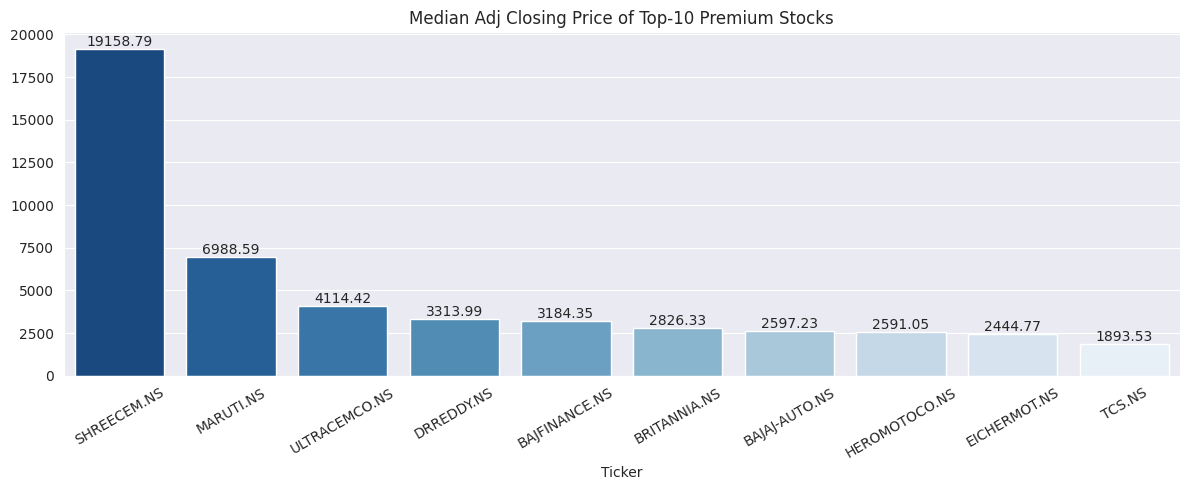

In [24]:
# Grouping stocks and checking their median adj close values
premium_stocks = df.groupby(by='Ticker')['Adj Close'].median().sort_values(ascending=False)[:10]

# Define a blue color palette and reverse it
blue_palette = sns.color_palette("Blues", n_colors=len(premium_stocks))[::-1]

# Plotting the Median Adj Closing Price of the top-10 premium stocks
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=premium_stocks.index, y=premium_stocks.values, palette=blue_palette)

# Rotate x-ticks by 45 degrees
plt.xticks(rotation=30)

# Annotate the bars with their median adj close values
for index, value in enumerate(premium_stocks.values):
    ax.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Set title and layout
plt.title('Median Adj Closing Price of Top-10 Premium Stocks')
plt.tight_layout()

# Show plot
plt.show()

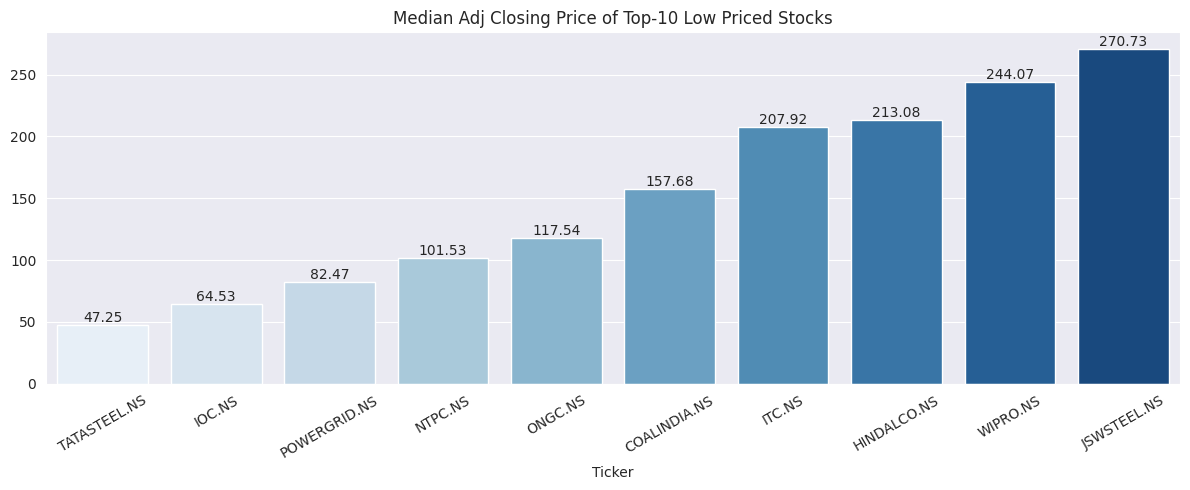

In [25]:
# Grouping stocks and checking their median adj close values
low_priced_stocks = df.groupby(by='Ticker')['Adj Close'].median().sort_values(ascending=True)[:10]

# Define a blue color palette and reverse it

# Plotting the Median Adj Closing Price of the top-10 premium stocks
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=low_priced_stocks.index, y=low_priced_stocks.values, palette=blue_palette[::-1])

# Rotate x-ticks by 30 degrees
plt.xticks(rotation=30)

# Annotate the bars with their median adj close values
for index, value in enumerate(low_priced_stocks.values):
    ax.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Set title and layout
plt.title('Median Adj Closing Price of Top-10 Low Priced Stocks')
plt.tight_layout()

# Show plot
plt.show()

### Observations:
* SHREECEM.NS, MARUTI.NS and ULTRACEMCOS.NS are the top 3 most-expensive stock options. These could be considered premium
* TATASTEEL.NS, IOC.NS and POWERGRID.NS are the top 3 least-expensive stock options available


In [26]:
# Extracting some information from the Date field and then setting it up as the dataframe's index

# Extracting the month
df['Month'] = df['Date'].dt.month

# Extracting the day of the week
df['Day_of_Week'] = df['Date'].dt.dayofweek

# Setting the Date column as the index
df.set_index('Date', inplace=True)

In [27]:
df['Day_of_Week'].value_counts()

Day_of_Week
2    22794
3    22749
1    22459
0    22364
4    22169
6       49
5       49
Name: count, dtype: int64

### Observations
* Its worth noting that the Stock Market is active during the week-days only. However, there are 49 occurences of the stock market being active on Saturday and Sunday as seen above

# Modelling Approach
There are two ways to go about when it comes to predicting and forecasting stocks. They are:
  1. <b>Predicting/Forecasting the Closing Price of a Stock </b> - This would mean that we predict the closing price for the stock tomorrow
  2. <b>Predicting the Stock Price Direction </b> - This would mean that we predict whether a stock's closing price is going to increase or decrease tomorrow. This would break down the problem into a binary-classification problem


  As the stock-market is very volatile and has extremely non-linear patterns that are heavily influences by external factors such as politics, sentiment of a brand, etc, predicting the price of the stock for the next day is a near-impossible task. A slightly easier task would be to attempt to predict stock price down the line (say 3 months in advance). However, even that would be a very difficult task to achieve.

 Instead, if we're able to identify stocks that may increase or decrease in price for the next day, it could bring a lot of value to the customers, as they can then make informed and educated investments. This would thus mean that the task would be a binary classification task.


   <b>Postive Class</b> -> Stock Price Increasing / Moving Up the next day<br>
   <b>Negative Class</b> -> Stock Price Decreasing / Moving Down the next day

   With this model set-up we can predict what stocks have the highest probability to go up in price the next day.


   <b>Metrics to use:</b>
   The long running goal here is to suggest what stocks would go up in price the next day. Instead of simply predicting that a stock would go up or down, we can predict the stocks that are most likely to go up (probability)
   
   In this context, False Positive has a higher weightage as compared to a False Negative as we want to make sure that what the model predicts is correct. Thus precision would make a lot of sense here.

   <b>Primary Metric: </b> Precision Score<br>
   <b>Supporting Metric: </b> Confusion Matrix

In [28]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Month,Day_of_Week
Date,,,,,,,,,
2015-01-01,319.000000,322.500000,316.250000,319.549988,304.542145,1456204,ADANIPORTS.NS,1,3
2015-01-01,867.400024,876.500000,862.250000,872.724976,807.734009,186924,DIVISLAB.NS,1,3
2015-01-01,826.500000,830.000000,818.099976,822.200012,767.332764,587479,SUNPHARMA.NS,1,3
2015-01-01,383.000000,383.450012,378.549988,380.049988,173.494568,540225,COALINDIA.NS,1,3
2015-01-01,1283.500000,1283.500000,1270.500000,1272.775024,1054.449951,366830,TCS.NS,1,3


In [29]:
# Shifting the Adjusted Closed day up by one unit to get the next day's Adj Close Price for each Ticker
df['Next_Day_Adj_Close'] = df.groupby('Ticker')['Adj Close'].shift(-1)

# Creating a new field that would serve as the target. If "Next_Day_Adj_Close" is greater than today's Adj Close Price, then we assign 1 else 0
df['Target'] = np.where(df['Next_Day_Adj_Close'] > df['Adj Close'], 1, 0)

# Dropping those rows where Next_Day_Adj_Close is missing as we do not have information of next day's price
df.dropna(subset=['Next_Day_Adj_Close'], inplace=True)

# Dropping the Next_Day_Adj_Close column
df.drop('Next_Day_Adj_Close', axis=1, inplace=True)

In [30]:
# Checking a single example

df[df['Ticker'] == 'ADANIPORTS.NS'][-5:]

,Open,High,Low,Close,Adj Close,Volume,Ticker,Month,Day_of_Week,Target
Date,,,,,,,,,,
2024-05-31,1391.0,1451.000000,1391.000000,1437.400024,1437.400024,8238969,ADANIPORTS.NS,5,4,1
2024-06-03,1549.0,1621.400024,1535.000000,1583.949951,1583.949951,23398347,ADANIPORTS.NS,6,0,0
2024-06-04,1558.0,1558.000000,1188.000000,1248.949951,1248.949951,52109624,ADANIPORTS.NS,6,1,1
2024-06-05,1281.0,1368.000000,1160.599976,1354.599976,1354.599976,20879925,ADANIPORTS.NS,6,2,0
2024-06-06,1384.0,1404.000000,1344.800049,1352.949951,1352.949951,12153840,ADANIPORTS.NS,6,3,1


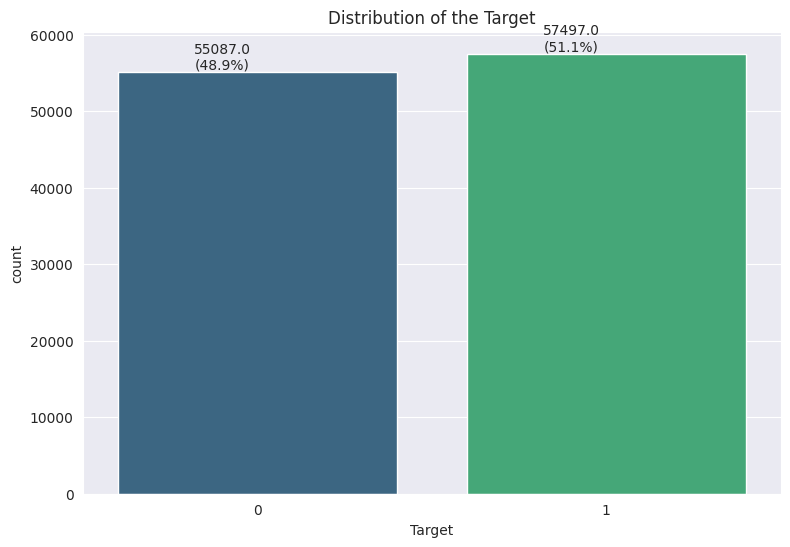

In [31]:
plt.figure(figsize=(9,6))

ax = sns.countplot(x='Target', data=df, palette='viridis')
# Calculate the percentages
total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height()
    ax.annotate(f'{count}\n({percentage})', (x, y), ha='center', va='bottom')

plt.title('Distribution of the Target')
plt.show()

### Observation:
* The classes are relatively balanced, with 51.1% datapoints corresponding to class 1 and 48.9% datapoints corresponding to class 0

# Building a simple-baseline model
This baseline model would simply predict that the price increases for all cases, and would help us understand what the simplest baseline score would be

Data Splitting Strategy:
There are multiple ways to split time series data. Back-Testing is a rigourous way to test how our model works on different validation datasets. However, to keep things simple, the first 90% of the dataset (sorted on Date) would be used for training, and the latest 10% would be used for testing.

In [32]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Month,Day_of_Week,Target
Date,,,,,,,,,,
2015-01-01,319.000000,322.500000,316.250000,319.549988,304.542145,1456204,ADANIPORTS.NS,1,3,0
2015-01-01,867.400024,876.500000,862.250000,872.724976,807.734009,186924,DIVISLAB.NS,1,3,1
2015-01-01,826.500000,830.000000,818.099976,822.200012,767.332764,587479,SUNPHARMA.NS,1,3,1
2015-01-01,383.000000,383.450012,378.549988,380.049988,173.494568,540225,COALINDIA.NS,1,3,1
2015-01-01,1283.500000,1283.500000,1270.500000,1272.775024,1054.449951,366830,TCS.NS,1,3,1


In [33]:
# Get the training and testing splits
X_train, y_train, X_val, y_val, X_test, y_test = get_time_based_splits(df, cut_off_threshold=0.9, validation_size=0.05)

print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (101325, 9), y_train Shape: (101325,)
X_val shape: (5629, 9), y_val Shape: (5629,)
X_test Shape: (5630, 9), y_test Shape: (5630,)


Precision Score: 0.52


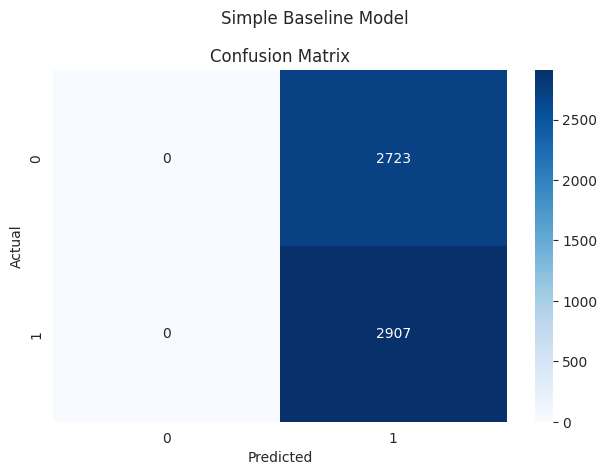

In [34]:
# Simple baseline model that predicts 1 for everything

y_pred_baseline = np.array([1] * len(y_test))
evaluate_model(y_test, y_pred_baseline, title='Simple Baseline Model')

### Observations:
* The Test Precision Score for the baseline model is 0.52
* This is as expected, and needs to be improved

# Building a simple RandomForest Model
In order to build the model, some pre-processing of the data would be required. This would mainly be about taking care of the categorical columns - "Ticker", "Month" and "Day_of_Week"

Since "Day_of_Week" takes over fewer values, it can be one-hot encoded. The Month and Ticker columns can be encoded using Target Encoding

In [35]:
# One-Hot Encoding the Day_of_Week column for the training data
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[['Day_of_Week']]), index=X_train.index)
ohe_df.columns = ohe.get_feature_names_out(['Day_of_Week'])
X_train = pd.concat([X_train, ohe_df], axis=1).drop('Day_of_Week', axis=1)

# Applying the same transformation to the test data
ohe_df_test = pd.DataFrame(ohe.transform(X_test[['Day_of_Week']]), index=X_test.index)
ohe_df_test.columns = ohe.get_feature_names_out(['Day_of_Week'])
X_test = pd.concat([X_test, ohe_df_test], axis=1).drop('Day_of_Week', axis=1)

In [36]:
# Getting the target-encoded values for the Month and the Ticker Column

month_train, month_mapping = target_encoder(X_train['Month'], y_train)
ticker_train, ticker_mapping = target_encoder(X_train['Ticker'], y_train)

# # Updating the Training data mapping
X_train['Month'] = month_train
X_train['Ticker'] = ticker_train

# # Updating the Test data mapping
X_test['Month'] = X_test['Month'].map(month_mapping)
X_test['Ticker'] = X_test['Ticker'].map(ticker_mapping)

In [37]:
X_train.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Month,Day_of_Week_0,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6
Date,,,,,,,,,,,,,,,
2015-01-01,319.000000,322.500000,316.250000,319.549988,304.542145,1456204,0.506679,0.49713,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-01,867.400024,876.500000,862.250000,872.724976,807.734009,186924,0.519084,0.49713,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-01,826.500000,830.000000,818.099976,822.200012,767.332764,587479,0.500954,0.49713,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-01,383.000000,383.450012,378.549988,380.049988,173.494568,540225,0.494275,0.49713,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-01,1283.500000,1283.500000,1270.500000,1272.775024,1054.449951,366830,0.516452,0.49713,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [38]:
# Running this through the Random Forest Model

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf_tr = rf.predict_proba(X_train)[:, 1]
y_pred_rf = rf.predict_proba(X_test)[:, 1]

Precision Score: 1.0


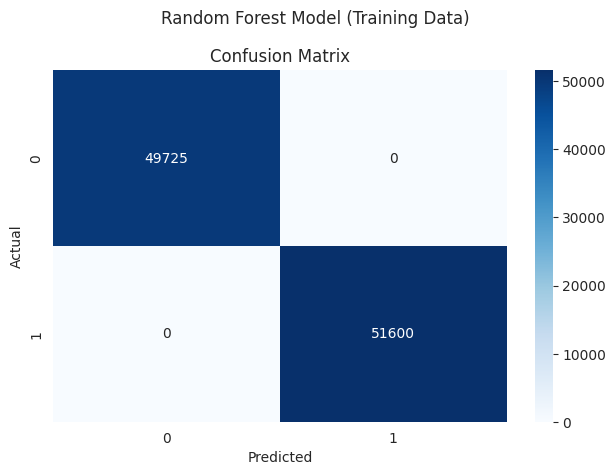

In [39]:
# Train Performance

evaluate_model(y_train, y_pred_rf_tr, title='Random Forest Model (Training Data)')

Precision Score: 0.51


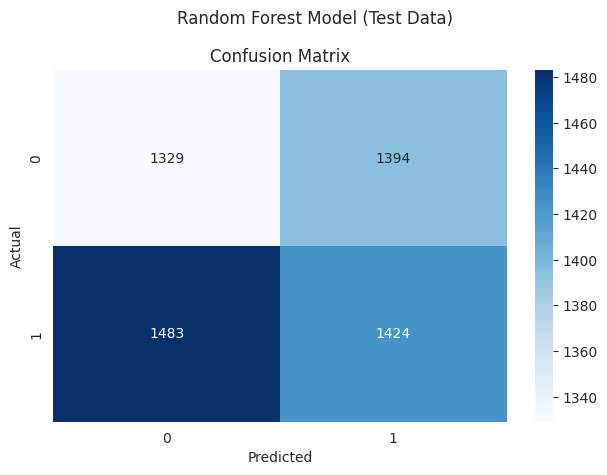

In [40]:
# Test Performance

evaluate_model(y_test, y_pred_rf, title='Random Forest Model (Test Data)')

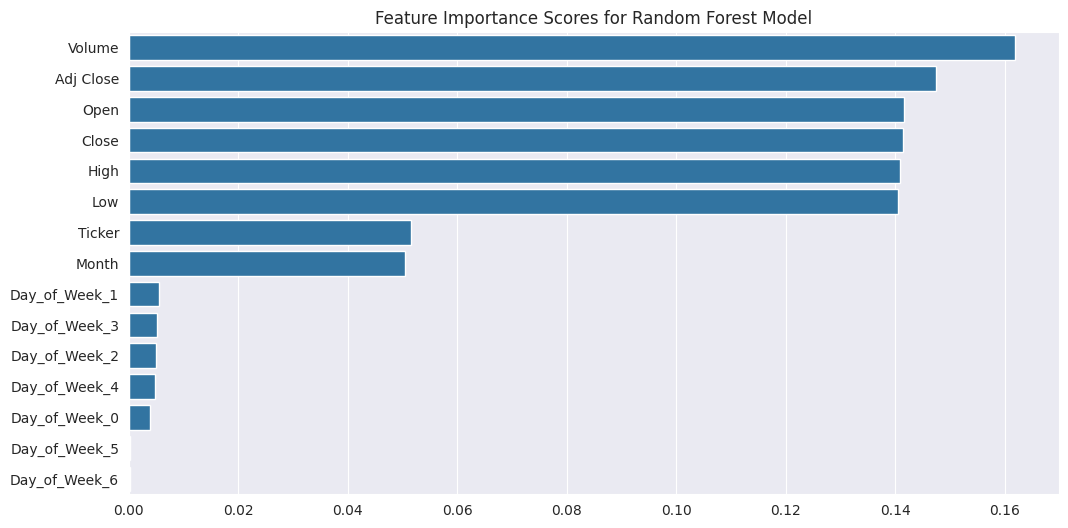

In [41]:
# Extract feature importances and corresponding feature names
feature_importances = rf.feature_importances_
features = X_train.columns

# Sort the feature importances and feature names in descending order of importance
indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[indices]
sorted_features = features[indices]

# Plot the sorted feature importance scores
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title('Feature Importance Scores for Random Forest Model')
plt.ylabel('')
plt.show()

### Observations:
* We can see right away that the model is absolutely over-fitting to the training dataset, resulting in train precision to be 1 and similarly the train roc-auc score to be 1, while on the other hand the model's performance on the test set is worse than the baseline score established earlier
* This may require some hyper-parameter tuning to hopefully fix the over-fitting issue
* The feature importance score suggests that the Day of Weeks have more or less no importance to the model, which makes sense, The stock market typically does not have any dependency on the day of the week. These columns can be dropped

## Experimenting with XGBoost

In [42]:
# Using xgboost

xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred_xg_tr = xgb_clf.predict_proba(X_train)[:, 1]
y_pred_xg = xgb_clf.predict_proba(X_test)[:, 1]

Precision Score: 0.63


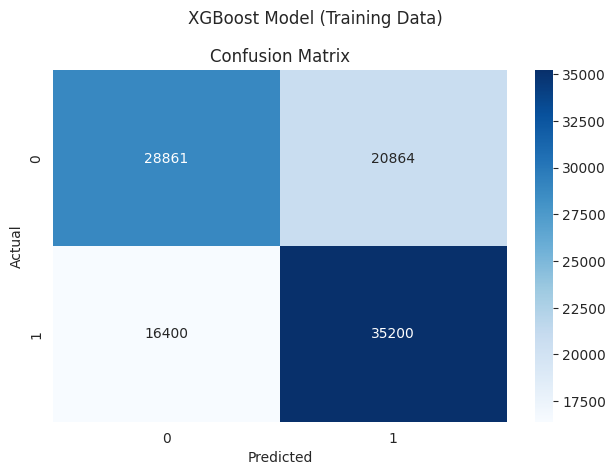

In [43]:
# Train Performance

evaluate_model(y_train, y_pred_xg_tr, title='XGBoost Model (Training Data)')

Precision Score: 0.5


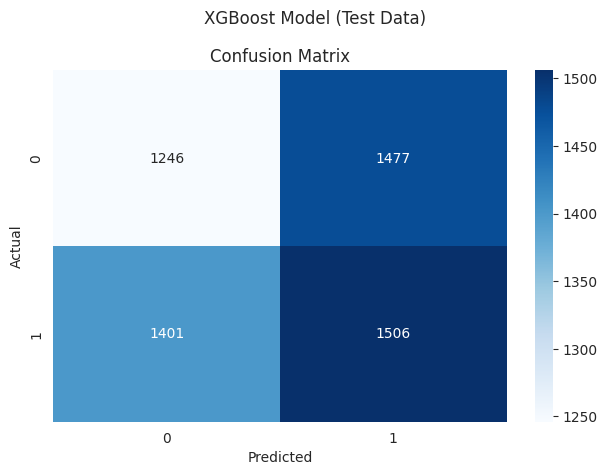

In [44]:
# Test Performance

evaluate_model(y_test, y_pred_xg, title='XGBoost Model (Test Data)')

### Observations:
* Just like RandomForest model, XGBoost is also over-fitting and we achieve similar test scores. This can however be fine-tuned to achieve slightly better test scores
* The model can benefit from adding newer features that give the model more insight

In [45]:
# Dropping the Day of Week column as we won't be needing it going forward

df.drop('Day_of_Week', axis=1, inplace=True)

# Brainstorming Potential Features
* Stock direction - Was the stock's closing price today greater than yesterday's closing price?
* Stock Close Price Percentage Change from Yesterday - What's the percentage change in the stock's adjusted closing price as compared to yesterday
* Stock Price Fluctuation - High - Low
* Stock Price Difference - Close - Open
* Rolling averages (2 day,  5 day, 60 day, 250 day)
* Close Ratios - Ratio of Adj Close Price / Rolling Avg
* Horizon Trends (2 day,  5 day, 60 day, 250 day) - Number of times stock price went up in the specified window



In [46]:
# Taking a backup of df before making changes

df_copy = df.copy()

In [47]:
# Creating stock direction feature - This would represent whether the closing
# price today was greater than the closing price from yesterday

df['Yesterday_Adj_Close'] = df.groupby('Ticker')['Adj Close'].shift(1)
df['Stock_Direction'] = np.where(df['Adj Close'] > df['Yesterday_Adj_Close'], 1, 0)

# Adding another feature that captures how much Adj Close changed in the span of
# one day
df['Adj_Close_Change'] = np.round((df['Adj Close'] - df['Yesterday_Adj_Close']) / df['Yesterday_Adj_Close'] * 100, 2)

# Dropping the Yesterday Adj Close Column
df.drop('Yesterday_Adj_Close', axis=1, inplace=True)

# Stock Price Fluctuation -> High - Low
df['Stock_Price_Fluctuation'] = df['High'] - df['Low']

# Stock Price Difference -> Close - Open
df['Stock_Price_Difference'] = df['Close'] - df['Open']

In [48]:
# Defining horizons for which rolling averages would be computed
horizons = [2, 5, 60, 250]

# Creating a column that shifts the target ahead
df['Target_Shifted'] = df.groupby('Ticker')['Target'].shift(1)

for horizon in horizons:
  # Calculating the rolling average of the Adj Close column
  df['Adj_Close_' + str(horizon) + '_Day_Rolling_Avg'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=horizon).mean())

  # Creating a new column to capture the ratio between the closing price and the rolling avg
  df['Close_Ratio_' + str(horizon)] = df['Adj Close'] / df['Adj_Close_' + str(horizon) + '_Day_Rolling_Avg']

  # Creating a column that captures the rolling sum of the number of times the target was 1 in the horizon window
  df['Trend_' + str(horizon)] = df.groupby('Ticker')['Target_Shifted'].transform(lambda x: x.rolling(window=horizon).sum())

# Dropping the target shifted column
df.drop('Target_Shifted', axis=1, inplace=True)

# Dropping all the null rows
df.dropna(inplace=True)

## Grouping Stocks coming from Similar industries or groups into one
Many of the stocks belong to companies that are in certain industry and thus grouping similar stocks can add some additional meaning to the model

In [49]:
# NOTE: Below dictionary has been created with the help of CHATGPT, and its accuracy may not be 100%

nifty_50_clusters = {
    # Cement
    'ULTRACEMCO.NS': 'Cement',
    'SHREECEM.NS': 'Cement',

    # Energy
    'COALINDIA.NS': 'Energy',
    'ONGC.NS': 'Energy',
    'RELIANCE.NS': 'Energy',
    'BPCL.NS': 'Energy',
    'IOC.NS': 'Energy',
    'NTPC.NS': 'Energy',
    'POWERGRID.NS': 'Energy',

    # Information Technology
    'TCS.NS': 'Information Technology',
    'WIPRO.NS': 'Information Technology',
    'INFY.NS': 'Information Technology',
    'TECHM.NS': 'Information Technology',
    'HCLTECH.NS': 'Information Technology',

    # Banking & Financial Services
    'M&M.NS': 'Banking & Financial Services',
    'INDUSINDBK.NS': 'Banking & Financial Services',
    'SBIN.NS': 'Banking & Financial Services',
    'AXISBANK.NS': 'Banking & Financial Services',
    'BAJAJFINSV.NS': 'Banking & Financial Services',
    'BAJFINANCE.NS': 'Banking & Financial Services',
    'KOTAKBANK.NS': 'Banking & Financial Services',
    'HDFCBANK.NS': 'Banking & Financial Services',
    'ICICIBANK.NS': 'Banking & Financial Services',
    'HDFCLIFE.NS': 'Banking & Financial Services',
    'SBILIFE.NS': 'Banking & Financial Services',

    # Automotive
    'TATAMOTORS.NS': 'Automotive',
    'MARUTI.NS': 'Automotive',
    'HEROMOTOCO.NS': 'Automotive',
    'EICHERMOT.NS': 'Automotive',
    'BAJAJ-AUTO.NS': 'Automotive',

    # Metals
    'JSWSTEEL.NS': 'Metals',
    'HINDALCO.NS': 'Metals',
    'TATASTEEL.NS': 'Metals',

    # Pharmaceuticals
    'DRREDDY.NS': 'Pharmaceuticals',
    'DIVISLAB.NS': 'Pharmaceuticals',
    'CIPLA.NS': 'Pharmaceuticals',
    'SUNPHARMA.NS': 'Pharmaceuticals',

    # FMCG
    'HINDUNILVR.NS': 'FMCG',
    'NESTLEIND.NS': 'FMCG',
    'BRITANNIA.NS': 'FMCG',
    'ITC.NS': 'FMCG',
    'TATACONSUM.NS': 'FMCG',

    # Conglomerates
    'GRASIM.NS': 'Conglomerates',
    'LT.NS': 'Conglomerates',

    # Others
    'BHARTIARTL.NS': 'Others',
    'TITAN.NS': 'Others',
    'ADANIPORTS.NS': 'Others',
    'ASIANPAINT.NS': 'Others',
    'UPL.NS': 'Others'
}

# Mapping the cluster group to the dataframe
df['Ticker_Group'] = df['Ticker'].map(nifty_50_clusters)

In [50]:
# Setting up a Chi-Square Test between the Ticker Group column and the Target column to see if ticker group adds and meaningful info

alpha = 0.05
chi2_test, p_value, _, _ = chi2_contingency(pd.crosstab(df['Ticker_Group'], df['Target']))

print(f"Chi-Square Test Statistic: {chi2_test}")
print(f"P-Value: {p_value}")

if p_value < alpha:
    print("There is a significant relationship between the Ticker Group and the Target.")
else:
    print("There is no significant relationship between the Ticker Group and the Target.")

Chi-Square Test Statistic: 12.112616068556745
P-Value: 0.20703476580319577
There is no significant relationship between the Ticker Group and the Target.


In [51]:
# Dropping the group feature as per the Chi Square result

df.drop('Ticker_Group', axis=1, inplace=True)

#  Modelling with the newer features

In [52]:
# Splitting the data

X_train, y_train, X_val, y_val, X_test, y_test = get_time_based_splits(df, cut_off_threshold=0.9, validation_size=0.05)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(90300, 24) (90300,)
(5017, 24) (5017,)
(5017, 24) (5017,)


In [53]:
# Carrying out some pre-processing of categorical columns

# Getting the target-encoded values for the Month and the Ticker Column

month_train, month_mapping = target_encoder(X_train['Month'], y_train)
ticker_train, ticker_mapping = target_encoder(X_train['Ticker'], y_train)

# Updating the Training data mapping
X_train['Month'] = month_train
X_train['Ticker'] = ticker_train

# Updating the Validation data mapping
X_val['Month'] = X_val['Month'].map(month_mapping)
X_val['Ticker'] = X_val['Ticker'].map(ticker_mapping)

# Updating the Test data mapping
X_test['Month'] = X_test['Month'].map(month_mapping)
X_test['Ticker'] = X_test['Ticker'].map(ticker_mapping)

In [54]:
# Fitting a basic XGBoost model

xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred_xg_tr = xgb_clf.predict_proba(X_train)[:, 1]
y_pred_xg = xgb_clf.predict_proba(X_test)[:, 1]

Precision Score: 0.68


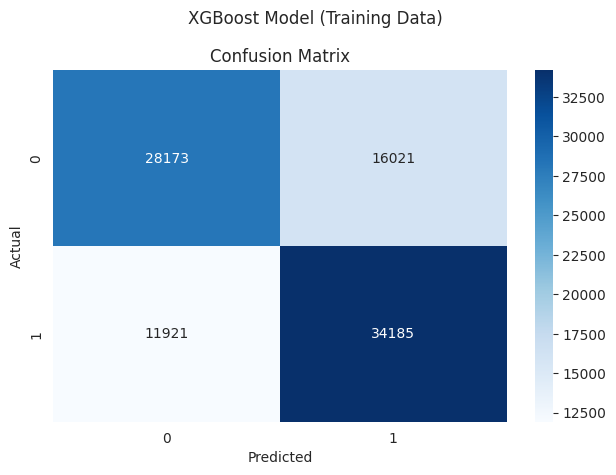

In [55]:
# Evaluating the model on the train dataset

evaluate_model(y_train, y_pred_xg_tr, title='XGBoost Model (Training Data)')

Precision Score: 0.51


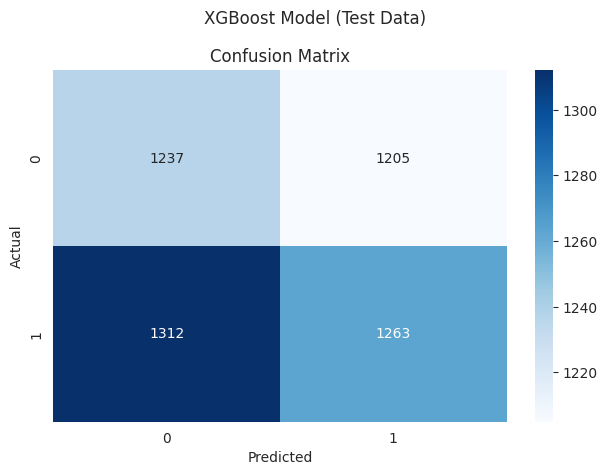

In [56]:
# Evaluating the model on the testing dataset

evaluate_model(y_test, y_pred_xg, title='XGBoost Model (Test Data)')

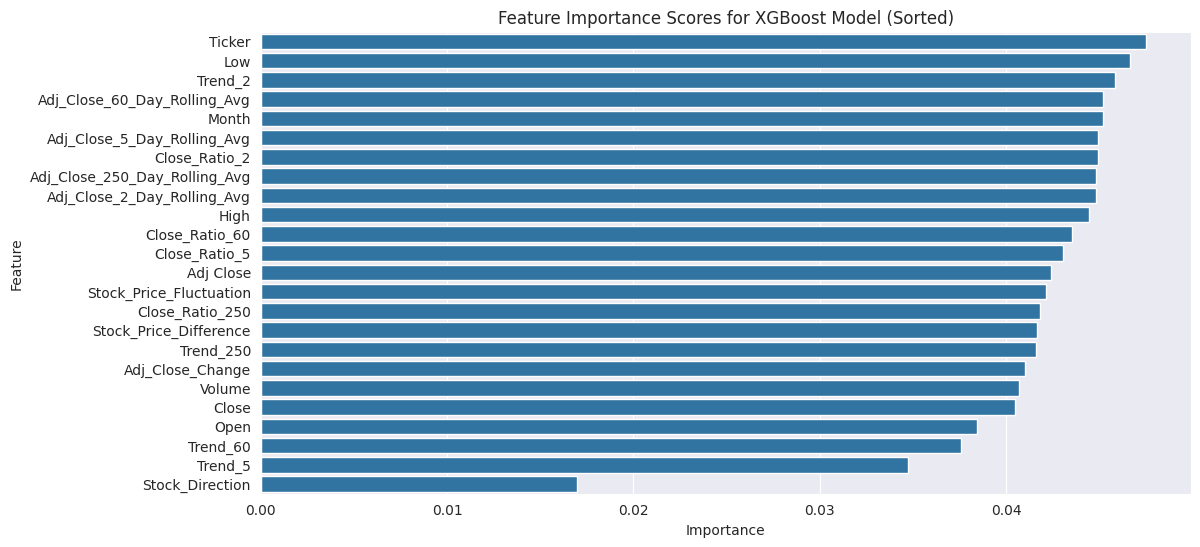

In [57]:
# Calculate feature importances
importances = xgb_clf.feature_importances_

# Create a DataFrame to store feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot the sorted feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance Scores for XGBoost Model (Sorted)')
plt.show()

### Observations:
* The newly added features seem to be adding some information to the model
* The test-set ROC has increased from 0.5 to 0.51 which is a 1% improvement on the earlier RandomForest and XGBoost Models
* The main focus right now should be on reducing the model over-fitting. This can be addressed by performing hyper-parameter tuning

# Hyper-Parameter Tuning the XGBoost Model

In [70]:
# Define a parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [1, 3, 5, 7, 9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

# Define the XGBoost classifier
#xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform hyperparameter tuning
#best_model, best_params, best_precision = hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid)

# print(f"Best parameters: {best_params}")
# print(f"Best Precision on validation set: {best_precision}")

100%|██████████| 900/900 [1:03:27<00:00,  4.23s/it]

Best parameters: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 400}
Best Precision on validation set: 0.5526007039499413


Precision Score: 0.51


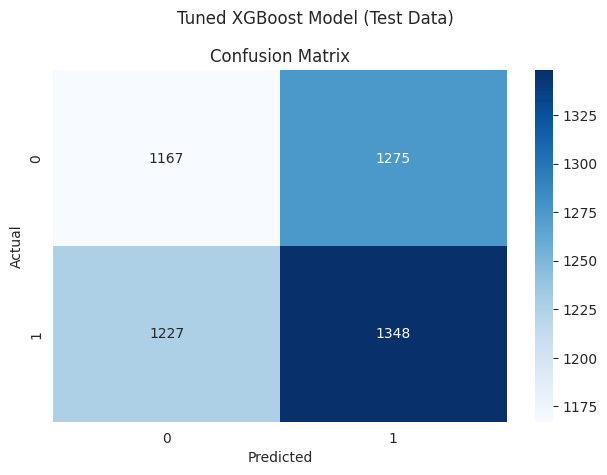

In [74]:
# Evaluate the best model on the test set
# y_test_pred_proba = best_model.predict_proba(X_test)[:, 0]

# evaluate_model(y_test, y_test_pred_proba, title='Tuned XGBoost Model (Test Data)')

In [75]:
# Running second iteration of grid-search, keeping certain hyper-parameters fixed

# Define a parameter grid
param_grid = {
    'n_estimators': [400, 500, 600, 700],
    'learning_rate': [0.3, 0.4, 0.5],
    'max_depth': [5],
    'gamma': [0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.01, 0.1, 1, 10]
}

# Define the XGBoost classifier
#xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform hyperparameter tuning
# best_model_v1, best_params_v1, best_precision_v1 = hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid)

# print(f"Best parameters: {best_params_v1}")
# print(f"Best Precision on validation set: {best_precision_v1}")

100%|██████████| 300/300 [41:00<00:00,  8.20s/it]

Best parameters: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1}
Best Precision on validation set: 0.554953560371517


Precision Score: 0.51


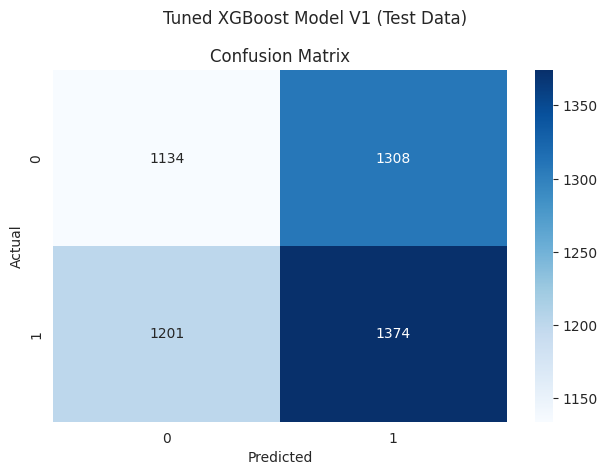

In [76]:
# Evaluate the best model on the test set
# y_test_pred_proba = best_model_v1.predict_proba(X_test)[:, 0]

# evaluate_model(y_test, y_test_pred_proba, title='Tuned XGBoost Model V1 (Test Data)')

### Observations:
* Post Hyper-parameter tuning, the best test-precision observed is 0.51
* Based on the confusion matrices, the first XGBoost model seems to be better than the tuned models (trained with the Feature Engineered features)

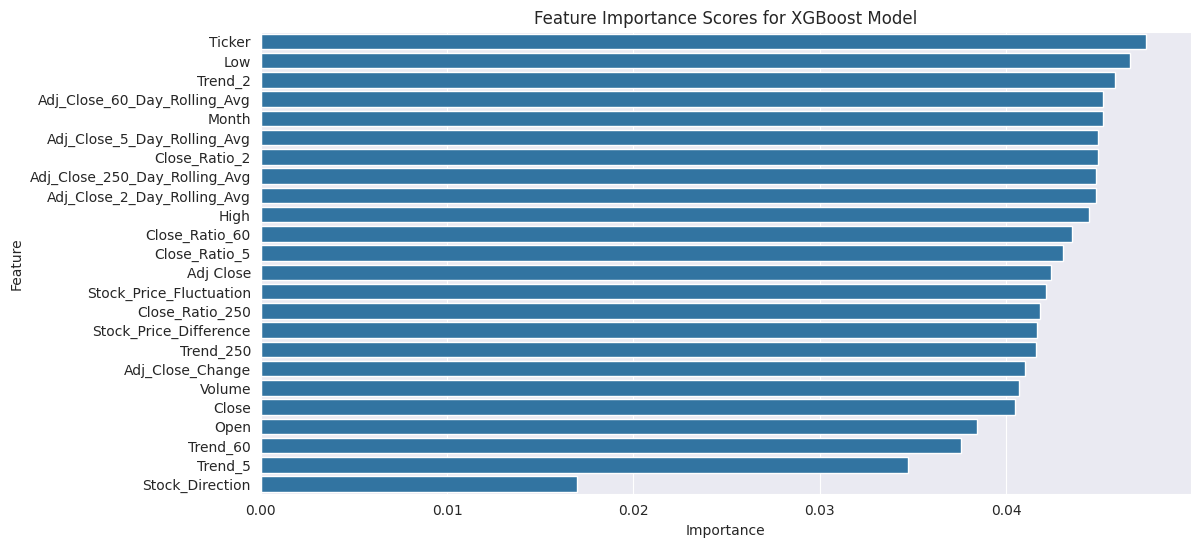

In [62]:
# Visualizing Feature Importances of the best model

importances = xgb_clf.feature_importances_

# Create a DataFrame to store feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot the sorted feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance Scores for XGBoost Model')
plt.show()

### Observations:
* The top 5 features that contribute towards predicting the Stock Direction are:
  1. Ticker (Stock ticker)
  2. Low (Lowest price for the stock, for the current day)
  3. Trend 2 (Engineered Feature)
  4. Adj_Close_5_Day_Rolling_Avg (Engineered Feature)
  5. Month

* The Feature Importances plot suggests that many of the engineered features contribut towards the model's predictions

In [64]:
# Saving the best model as a pickle file

with open('best_model.pkl', 'wb') as f:
    pickle.dump(xgb_clf, f)

In [86]:
# Analyzing model performance on test set

model_test_preds = xgb_clf.predict(X_test)

In [87]:
# Define a dictionary that maps Ticker encoded values back to actual tickers

encoded_ticker_mapping = {v: k for k, v in ticker_mapping.items()}

# Creating new dataframe and mapping ticker back to the df

X_test_copy = X_test.copy()

X_test_copy['Ticker'] = X_test_copy['Ticker'].map(encoded_ticker_mapping)

# Adding labels to X_test df
X_test_copy['Target'] = y_test

# Adding predictions to X_test df
X_test_copy['Predictions'] = model_test_preds

In [88]:
# Calculating precision for each ticker in the validation data-set

ticker_precisions = {}

for ticker in X_test_copy['Ticker'].unique():
    ticker_df = X_test_copy[X_test_copy['Ticker'] == ticker]
    ticker_precision = precision_score(ticker_df['Target'], ticker_df['Predictions'])
    ticker_precisions[ticker] = ticker_precision

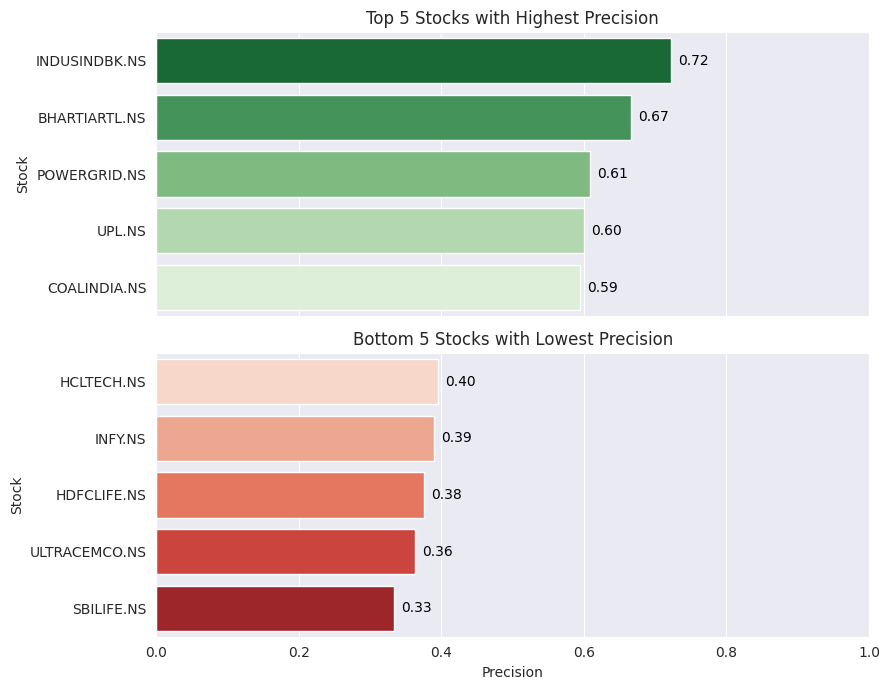

In [100]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(ticker_precisions.items()), columns=['Stock', 'Precision'])

# Sort the DataFrame by Precision
df_sorted = df.sort_values(by='Precision', ascending=False)

# Get the top 5 and bottom 5 stocks
top_5_stocks = df_sorted.head(5)
bottom_5_stocks = df_sorted.tail(5)

fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

# Plot the top 5 stocks
sns.barplot(x='Precision', y='Stock', data=top_5_stocks, ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 5 Stocks with Highest Precision')
axes[0].set_xlim(0, 1)

# Annotate the bars with precision values
for index, value in enumerate(top_5_stocks['Precision']):
    axes[0].text(value + 0.01, index, f'{value:.2f}', color='black', va="center")

# Plot the bottom 5 stocks
sns.barplot(x='Precision', y='Stock', data=bottom_5_stocks, ax=axes[1], palette='Reds')
axes[1].set_title('Bottom 5 Stocks with Lowest Precision')
axes[1].set_xlim(0, 1)

# Annotate the bars with precision values
for index, value in enumerate(bottom_5_stocks['Precision']):
    axes[1].text(value + 0.01, index, f'{value:.2f}', color='black', va="center")

plt.tight_layout()
plt.show()

### Observations:
* Based on the above analysis, we see that the model does well wrt Precision on stocks such as -
   1. INDUSINDBK.NS (0.72)
   2. BHARTIARTL.NS (0.67)
   3. POWERGRID.NS (0.61)

* On the other end, the model performs very poorly on stocks such as -
   1. SBILIFE.NS (0.33)
   2. ULTRACEMCO.NS (0.36)
   3. HDFCLIFE.NS (0.38)


# Take-aways, Insights and Recommendations:
Predicting the stock-market is a very difficult task, even when using the most sophesticated algorithms. We've seen that improving on the base line Precision of <b>0.52</b> is complicated even after a good amount of Feature Engineering.

However, some important take-aways from the analysis are -
* Best Stocks to invest in based on last month's performance -
   1. <b>M&M.NS</b>
   2. <b>HEROMOTOCO.NS</b>
   3. <b>HINDALCO.NS</b>

* Similarly, best stocks to invest in, based on last year's performance -
   1. <b>NTPC.NS</b>
   2. <b>COALINDIA.NS</b>
   3. <b>IOC.NS</b>

* <b>IOC.NS</b> has one of the most-cost efficient stock prices, and have grown tremendously over the last year and can be a really smart investment option

* The Test-Precision score of the model is <b>0.51</b>, which means that of all the times the model predicts that a stock is going to go up in price, <b>51%</b> of those times the model would get it right. This is lower than the baseline heuristic model by <b>1%</b>

* However, we've seen that the model's precision on the test set varies for different stock options. An example of this is having a precision score of <b>0.72</b> for <b>INDUSINDBK.NS</b> whereas having a precision score of <b>0.33</b> for <b>SBILIFE.NS</b>

* The XGBoost Model found the following features really useful for predicting the stock price movement -
   1. <b>Ticker (Stock ticker)</b>
   2. <b>Low (Lowest price for the stock, for the current day)</b>
   3. <b>Trend 2 (Engineered Feature)</b>
   4. <b>Adj_Close_5_Day_Rolling_Avg (Engineered Feature)</b>
   5. <b>Month</b>

# Next Steps to improve Predictive Performance
* Predicting the movement of 49 stocks is a very complicated task. Here are some next steps that can be taken to improve the predictive performance -
   1. <b>Limiting the Scope</b> - We've seen the model doing well on some stocks and terribly on others. It would make sense to have the model predict only a single stock's movement instead of 49 stocks
   2. <b>Increasing the Data</b> - The data is capped to only include stock data up-till 2015. We can fetch older data in order to get the model more datapoints so that we can reduce the over-fitting
   3. <b>Engineering Better Features</b> - There are more features that can help greatly to predict the movement of stock prices that are commonly used by financial analysts such as Relative Strength Index (RSI), Bollinger Bands, etc.
   4. <b>Experimenting with LSTM Models</b> - LSTM's are well known Recurrent Neural Networks that are capable of modeeling sequence data. By collecting more data, we can leverage the power of LSTM to improve the precision score
